# Проект «Прогнозирование заказов такси»

### Описание задачи

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.
Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.
Нам необходимо построить модель для такого предсказания.

### Описание данных

* datetime — дата и время
* num_orders — количество заказов такси

## Загрузка библиотек

In [1]:
!pip install statsmodels

DEPRECATION: Loading egg at /usr/lib64/python3.11/site-packages/TBB-2021.12.0-py3.11-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try
    zypper install python311-xyz, where xyz is the package
    you are trying to install.
    
    If you wish to install a non-rpm packaged Python package,
    create a virtual environment using python3.11 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-rpm packaged Python application,
    it may be easiest to use `pipx install xyz`, which will manage a
    virtual environment for you. Install pipx via `zypper install python311-pipx` .

note: If you believe this is a mistake, please contact your Py

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Примечание: в новой версии библиотеки sklearn вычисление RMSE будет производится иначе (не как указано в теории)
# На всякий случай, добавил оба варианта.

In [4]:
try:
    from sklearn.metrics import mean_squared_error
except:
    from sklearn.metrics import root_mean_squared_error

In [5]:
RANDOM_STATE = 12345

## Загрузка данных

In [6]:
filename = 'taxi.csv'

In [7]:
try:
    data = pd.read_csv('/datasets/' + filename)
except:
    data = pd.read_csv(filename)

#### Осмотр данных

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Видим, что датасет полный (без NaN'ов).

Посмотрим на первые 5 строк датасета.

In [9]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Датасет загрузился корректно.
Данные в датасете соответствуют описанию.

### Ресемплирование данных

Установим индекс датасета равным столбцу datetime и отсортируем датасет по времени.

In [10]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
data.sort_index(inplace=True)

Т.к. нам необходимо прогнозировать количество заказов такси на следующий час, выполним ресемплирование данных по одному часу.

In [11]:
data = data.resample('1H').sum();

/tmp/ipykernel_187477/2115578818.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('1H').sum();


## Анализ данных

Посмотрим на наш временной ряд, заодно посчитав скользящее среднее с окном, равным 24 часам (одним суткам).

In [12]:
data['rolling_mean'] = data.rolling(24).mean()

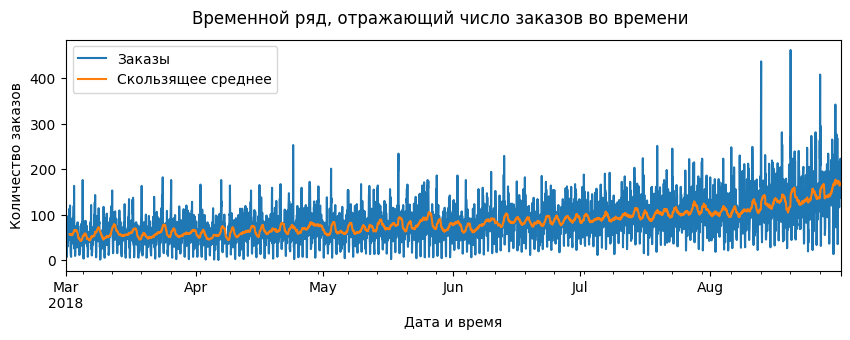

In [13]:
fig, ax = plt.subplots(figsize=(10, 3))
data.plot(ax=ax)
ax.set(xlabel='Дата и время', ylabel='Количество заказов')
fig.suptitle('Временной ряд, отражающий число заказов во времени')
ax.legend(labels=['Заказы', 'Скользящее среднее'])
plt.show()

Видим общую тенденцию к росту числа заказов во времени от марта к концу августа.

### Тренд и сезонность

Разложим наш ряд на тренд и сезонность

In [14]:
decomposed = seasonal_decompose(data['num_orders'])

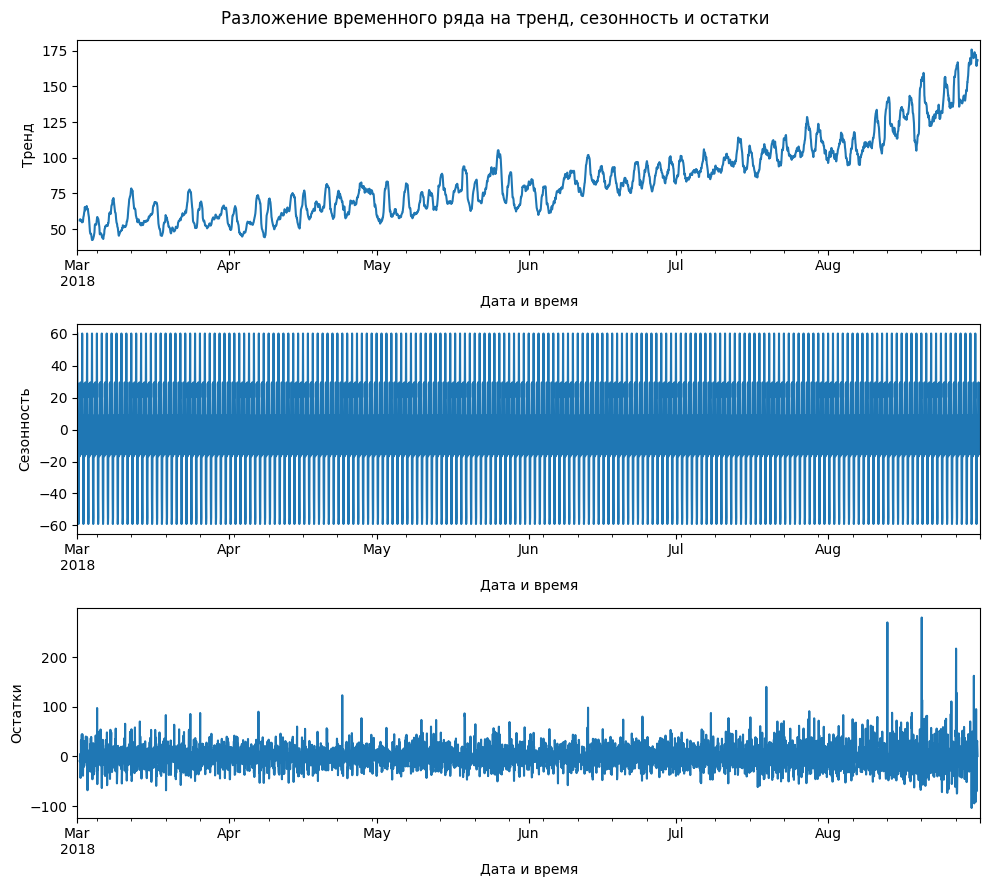

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(10, 9))
fig.suptitle('Разложение временного ряда на тренд, сезонность и остатки')

decomposed.trend.plot(ax=ax[0], xlabel='Дата и время', ylabel='Тренд')
decomposed.seasonal.plot(ax=ax[1], xlabel='Дата и время', ylabel='Сезонность')
decomposed.resid.plot(ax=ax[2], xlabel='Дата и время', ylabel='Остатки')

plt.tight_layout()

Видим, что тренд на протяжении всего времени растет, особенно определенно с середины июня по конец августа,— со временем все большее
количество людей пользуется услугой такси.

Сезонность выглядит стабильной, однако график слишком плотный.
Рассмотрим 2 периода покороче: одна неделя в весеннем месяце (апрель) и одна — в летнем (июль).

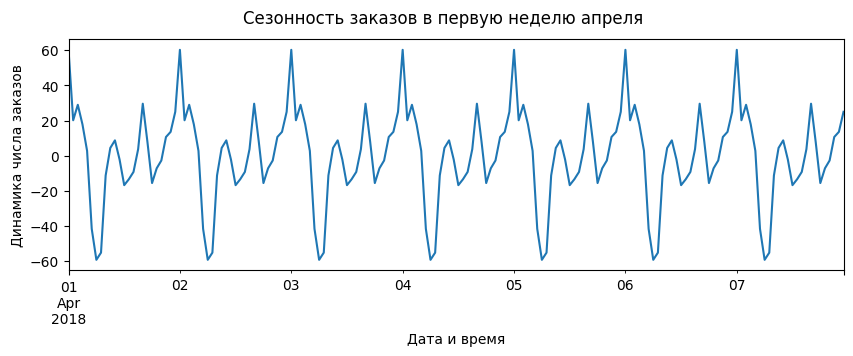

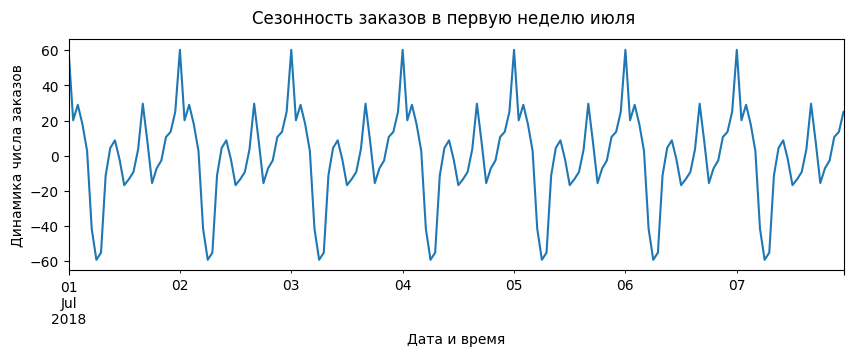

In [16]:
fig, ax = plt.subplots(figsize=(10, 3))
decomposed.seasonal['2018-04-01':'2018-04-07'].plot(ax=ax)
ax.set(xlabel='Дата и время', ylabel='Динамика числа заказов')
fig.suptitle('Сезонность заказов в первую неделю апреля')
plt.show()

fig, ax = plt.subplots(figsize=(10, 3))
decomposed.seasonal['2018-07-01':'2018-07-07'].plot(ax=ax)
ax.set(xlabel='Дата и время', ylabel='Динамика числа заказов')
fig.suptitle('Сезонность заказов в первую неделю июля')
plt.show()

Видим одинаковую цикличность заказов по суткам что весной, что летом: максимум заказов наступает к полуночи, а минимум — в утренние часы наступивших
суток.

#### Подготовка признаков

Удалим существующий столбец со скользящих средним, т.к. в ходе создания признаков будет создан новый.

In [17]:
data.drop('rolling_mean', axis=1, inplace=True)

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()

    return data

Создаем признаки и подготавливаем выборки:

In [19]:
data = make_features(data, 24, 24)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

Инициализируем TimeSeriesSplit для кросс-валидации временных рядов.

In [20]:
tscv = TimeSeriesSplit()

## Обучение моделей

### LightGBM

Рассмотрим модель LightGBM и найдем лучшие гиперпараметры для нее.

In [21]:
lgbm = LGBMRegressor()

Зададим параметры

In [22]:
params = {
    'n_estimators': [50, 100, 200],
    'num_leaves': [10, 50, 70, 100],
    'random_state': [RANDOM_STATE]
}

In [23]:
grid = GridSearchCV(
    lgbm,
    params,
    cv = tscv,
    scoring = 'neg_root_mean_squared_error'
)

In [24]:
%%time
grid.fit(X_train, y_train);
print(grid.best_params_)
print(grid.best_score_ * (-1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2688
[LightGBM] [Info] Number of data points in the train set: 660, number of used features: 27
[LightGBM] [Info] Start training from score 57.103030
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 1318, number of used features: 27
[LightGBM] [Info] Start training from score 59.327769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3710
[LightGBM] [Info] Number of data points in the train set:

Видим неплохой RMSE.
Видим, что лучшие параметры модели: num_leaves — 10, n_estimators — 200.

### Решающее дерево

Обучим модель решающего дерева и получим лучшие гиперпараметры для него.

In [25]:
model_dtreer = DecisionTreeRegressor()

In [26]:
params = {
    'max_depth': range(2, 12),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 5),
    'random_state': [RANDOM_STATE]
}

In [27]:
grid = GridSearchCV(
    model_dtreer,
    params,
    cv=tscv,
    scoring = 'neg_root_mean_squared_error'
)

In [28]:
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_ * (-1))

{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 12345}
29.435532875534033


Видим, что RMSE хуже, чем у LightGBM

### Случайный лес

Обучим модель случайного леса и найдем лучшие значения гиперпараметров для нее.

In [29]:
model_rforr = RandomForestRegressor()

In [30]:
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [2, 5, 10, 20],
    'random_state': [RANDOM_STATE]
}

In [31]:
grid = GridSearchCV(
    model_rforr,
    params,
    cv=tscv,
    scoring = 'neg_root_mean_squared_error'
)

In [32]:
%%time
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_ * (-1))

{'max_depth': 20, 'n_estimators': 100, 'random_state': 12345}
25.230852751031808
CPU times: user 1min 30s, sys: 0 ns, total: 1min 30s
Wall time: 1min 30s


Видим, что RMSE чуть хуже, чем у LightGBM.
Поэтому в качестве лучшей выберем LightGBM

### Качество лучшей модели на тестовой выборке

In [33]:
%%time
lgbm = LGBMRegressor(n_estimators=200, num_leaves=10, random_state=RANDOM_STATE)
lgbm.fit(X_train, y_train);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4836
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 27
[LightGBM] [Info] Start training from score 78.421013
CPU times: user 464 ms, sys: 0 ns, total: 464 ms
Wall time: 106 ms


Отметим, что обучается LightGBM достаточно быстро.

In [34]:
y_pred = lgbm.predict(X_test)

In [35]:
try:
    rmse = mean_squared_error(y_test, y_pred, squared=False)
except:
    rmse = root_mean_squared_error(y_test, y_pred)

rmse

/usr/lib64/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(40.99997607065316)

Качество модели удовлетворяет условию (ниже целевого порога 48)

Посмотрим как графически выглядит прогноз относительно истинных значений на тестовой выборке

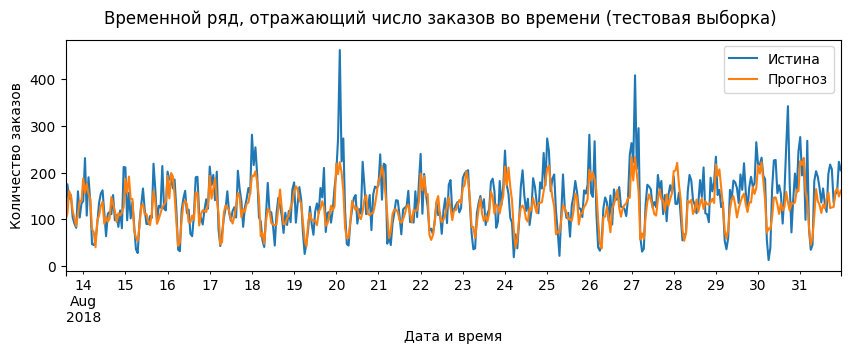

In [36]:
fig, ax = plt.subplots(figsize=(10, 3))
pd.concat([y_test, pd.Series(y_pred, index=y_test.index)], axis=1).plot(ax=ax)
ax.set(xlabel='Дата и время', ylabel='Количество заказов')
fig.suptitle('Временной ряд, отражающий число заказов во времени (тестовая выборка)')
ax.legend(labels=['Истина', 'Прогноз'])
plt.show()

Видим, что в общем прогнозный ряд неплохо аппроксимирует истинный, однако же в моменты скачков вверх заказов (пики на графике) модель выдает
заниженный прогноз.
При этом скачки вниз модель предсказывает неплохо.

## Общий вывод

Был проведен анализ временного ряда и получены следующие результаты:

На этапе анализа данных были установлены тренд и сезонность, а также созданы новые признаки трех типов: календарные, отстающие значения
и скользящее среднее.

Были обучены 3 модели регрессии — LightGBM, решающее дерево и случайный лес — и найдены лучшие значения гиперпараметров этих моделей.
Лучшее значение RMSE продемонстрировала модель LightGBM, которая и была выбрана в качестве лучшей.

Проверка качества на тестовой выборке также продемонстрировала отвечающий условиям задачи результат с точки зрения качества по метрике RMSE.